In [1]:
import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
# from skorch import NeuralNetClassifier
from confused import make_confusion_matrix

from statistics import mean, stdev
import random
import pickle

from features import generate_final_dataset, gen_rawData, load_data_paths, getInputVector, segment_df, concatenator, plot_confusion_matrix

In [2]:
TRAIN_FILEPATH = "./capstone_data/train/*.csv"
TEST_FILEPATH = "./capstone_data/test/*.csv"

DANCE_MOVES = ["jamesbond", "dab", "mermaid"]
IN_FEATURES = 480
OUT_FEATURES = 3
HIDDEN_LAYER_1_NODES = 80
HIDDEN_LAYER_2_NODES = 40
K = 3   
EPOCHS = 50
TRAIN_BATCH_SIZE = 108
LEARNING_RATE = 0.01
NUM_TO_DANCE_MAP = {0: 'dab', 1: 'jamesbond', 2: 'mermaid'}

In [3]:
# test
test_dic = generate_final_dataset(gen_rawData(load_data_paths(TEST_FILEPATH)))
data_test, lbl_test = segment_df(concatenator(test_dic), "target")
testing_X = getInputVector(data_test)
print(f"testing_X input vector shape : {testing_X.shape}")
print(f"labels for test shape: {lbl_test.shape}")

# train
train_dic = generate_final_dataset(gen_rawData(load_data_paths(TRAIN_FILEPATH)))
data_train, lbl_train = segment_df(concatenator(train_dic), "target")
training_X = getInputVector(data_train)
print(f"training_X input vector shape : {training_X.shape}")
print(f"labels for train shape: {lbl_train.shape}")

# X_train = torch.FloatTensor(training_X)
# X_test = torch.FloatTensor(testing_X)
# y_train = torch.LongTensor(lbl_train)
# y_test = torch.LongTensor(lbl_test)
X_train = np.asarray(training_X)
X_test = np.asarray(testing_X)
y_train = np.asarray(lbl_train)
y_test = np.asarray(lbl_test)

testing_X input vector shape : (538, 480)
labels for test shape: (538,)
training_X input vector shape : (2698, 480)
labels for train shape: (2698,)


In [4]:
def fold_trainer(model, x,y, name):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores = []
    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x[train_index], x[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model.fit(x_train_fold, y_train_fold)
        scores.append(model.score(x_test_fold, y_test_fold))
    print(f"-------------------------{name}--------------------------------")
    print()
    print('List of possible accuracy:', scores)
    print(f"\nMaximum Accuracy That can be obtained from {name} is:", max(scores)*100, '%')
    print('\nMinimum Accuracy:',min(scores)*100, '%')
    print('\nOverall Accuracy:',mean(scores)*100, '%')
    print('\nStandard Deviation is:', stdev(scores))
    print(f"---------------------------------------------------------------")
    print()

In [5]:
# class NeuralNet(nn.Module):
#     def __init__(self, in_features = IN_FEATURES, h1= HIDDEN_LAYER_1_NODES, h2 = HIDDEN_LAYER_2_NODES, out_features = OUT_FEATURES):
#         super().__init__()
#         self.fc1 = nn.Linear(in_features,h1)    # input layer
#         self.fc2 = nn.Linear(h1, h2)            # hidden layer
#         self.out = nn.Linear(h2, out_features)  # output layer
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.out(x)
#         return x

In [6]:
# torch.manual_seed(0)
# net = NeuralNetClassifier(
#     NeuralNet,
#     max_epochs=EPOCHS,
#     lr=LEARNING_RATE,
#     batch_size=TRAIN_BATCH_SIZE,
#     optimizer=torch.optim.Adam,
#     criterion=nn.CrossEntropyLoss,
#     train_split=None
# )
exClf = ExtraTreesClassifier(n_estimators=100, random_state=0)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo')
knn = KNeighborsClassifier()

In [7]:
vc = VotingClassifier(estimators = [('svm',poly),('exClf',exClf), ('knn', knn)], voting='hard')
fold_trainer(vc,X_train,y_train,"Voting-Classifier")

-------------------------Voting-Classifier--------------------------------

List of possible accuracy: [0.9851851851851852, 0.9851851851851852, 0.9851851851851852, 0.9888888888888889, 1.0, 0.9962962962962963, 0.9962962962962963, 0.9814814814814815, 0.9888475836431226, 0.9851301115241635]

Maximum Accuracy That can be obtained from Voting-Classifier is: 100.0 %

Minimum Accuracy: 98.14814814814815 %

Overall Accuracy: 98.92496213685806 %

Standard Deviation is: 0.006164837036484883
---------------------------------------------------------------



              precision    recall  f1-score   support

           0       0.82      0.98      0.89       182
           1       0.98      0.94      0.96       180
           2       0.98      0.82      0.89       176

    accuracy                           0.91       538
   macro avg       0.92      0.91      0.91       538
weighted avg       0.92      0.91      0.91       538



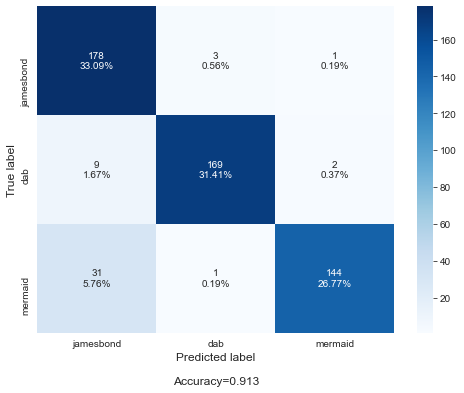

In [8]:
y_preds = vc.predict(X_test)
print(classification_report(lbl_test, y_preds))
cmt = confusion_matrix(lbl_test, y_preds)
make_confusion_matrix(cmt,categories=DANCE_MOVES, figsize=(8,6))
# print(X_test.shape)

In [9]:
# testing with a random sample from test set 
random.seed(69)
random_int = random.randint(0, len(testing_X))
random_input = np.asarray(testing_X[random_int]).reshape(-1,480)
print(random_input.shape)

(1, 480)


In [10]:
def getPrediction(arr):
    out = vc.predict(arr)
    return NUM_TO_DANCE_MAP[out[0]]

In [11]:
getPrediction(random_input)

'mermaid'

In [12]:
# saving
with open('ensemble.pkl', 'wb') as f:
    pickle.dump(vc, f)